## Finding differentialy expressed miRNA's between LUAD stages I, II, III, IV vs normal using Logit regression
### Utilize Group Lasso with MISIM miRNA similarity data

In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2\
    
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt

from definitions import ROOT_DIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load normal and cancer miRNA expression data

In [2]:
from definitions import ROOT_DIR

# Load files into pandas data frames
mirna_tumor_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/tumor_miRNA.csv"))
mirna_normal_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/miRNA/normal_miRNA.csv"))
clinical_df = pandas.read_csv(os.path.join(ROOT_DIR, "data/processed/clinical/clinical.csv"))
validated_miRNA_csv = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))

# Print data frame shapes
print "mirna_tumor_df.shape", mirna_tumor_df.shape, ', nulls:', mirna_tumor_df.isnull().sum().sum()
print "mirna_normal_df.shape", mirna_normal_df.shape, ', nulls:', mirna_normal_df.isnull().sum().sum()
print 'validated_miRNAs.shape', validated_miRNA_csv.shape

# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
mirna_normal = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_normal_df, on='patient_barcode')
mirna_normal['pathologic_stage'] = 'normal'
mirna_tumor = pandas.merge(clinical_df[['patient_barcode', 'pathologic_stage']], mirna_tumor_df, on='patient_barcode')

mirna_tumor.dropna(inplace=True)
mirna_normal.dropna(inplace=True)

# Map stage IA to stage I, IB to I, etc. ...
pathologic_stage_map = {'Stage IA': 'Stage I', 'Stage IB': 'Stage I', 
                        'Stage IIA': 'Stage II', 'Stage IIB': 'Stage II', 
                        'Stage IIIA': 'Stage III', 'Stage IIIB': 'Stage III'}
mirna_tumor.replace({'pathologic_stage': pathologic_stage_map}, inplace=True)

# Store list of all miRNA's in miRNA expression data
mirna_list = list(mirna_tumor.columns)[2:]

# Print quick overview of data
print mirna_normal['pathologic_stage'].value_counts().sort_index(axis=0)
print mirna_tumor['pathologic_stage'].value_counts().sort_index(axis=0)

mirna_tumor_df.shape (513, 1882) , nulls: 0
mirna_normal_df.shape (46, 1882) , nulls: 0
validated_miRNAs.shape (34, 2)
normal    46
Name: pathologic_stage, dtype: int64
Stage I      277
Stage II     121
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64


## Load normal & cancer Gene Expression data

In [3]:
gene_exp_tumor_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/tumor/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')
gene_exp_normal_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/processed/gene_expression/normal/READ__illuminahiseq_rnaseqv2__GeneExp.txt'), 
                                      header=0, delimiter='\t')

gene_exp_tumor_df.rename(columns=lambda x: x[:12], inplace=True)
gene_exp_normal_df.rename(columns=lambda x: x[:12], inplace=True)

print gene_exp_tumor_df.shape
print gene_exp_normal_df.shape

(20530, 517)
(20530, 61)


## Reshape gene expression data frames to have shape (patients x gene expression) 

In [4]:
# Remove entries with unknown Gene Symbol
gene_exp_tumor_df = gene_exp_tumor_df[gene_exp_tumor_df.GeneSymbol != '?']
gene_exp_normal_df = gene_exp_normal_df[gene_exp_normal_df.GeneSymbol != '?']

# Get list of all gene_symbols
gene_symbols = list(gene_exp_tumor_df['GeneSymbol'])
# Get list of tumor and normal patient_barcode
gene_exp_tumor_patient_barcodes = list(gene_exp_tumor_df.columns)[2:]
gene_exp_normal_patient_barcodes = list(gene_exp_normal_df.columns)[2:]

# Drop EntrezID column
gene_exp_tumor = gene_exp_tumor_df.drop(['EntrezID', 'GeneSymbol'], axis=1)
gene_exp_normal = gene_exp_normal_df.drop(['EntrezID', 'GeneSymbol'], axis=1)

# Reshaping data frame to have columns for GeneSymbols, and rows of patients
gene_exp_tumor = gene_exp_tumor.T
gene_exp_normal = gene_exp_normal.T
gene_exp_tumor.columns = gene_symbols
gene_exp_normal.columns = gene_symbols

# Add column for patients barcode
gene_exp_tumor['patient_barcode'] = gene_exp_tumor.index
gene_exp_normal['patient_barcode'] = gene_exp_normal.index

print "gene_symbols", len(gene_symbols)
print "gene_exp_tumor_patients", len(gene_exp_tumor_patient_barcodes)
print "gene_exp_normal_patients", len(gene_exp_normal_patient_barcodes)

print gene_exp_tumor.shape
print gene_exp_normal.shape

gene_symbols 20502
gene_exp_tumor_patients 515
gene_exp_normal_patients 59
(515, 20503)
(59, 20503)


## Filter samples with matched Gene Expression data and miRNA data
## More data preprocessing

In [5]:
# Merge normal and tumor miRNA expression profiles with clinical cancer stage data
merged_tumor_patients = pandas.merge(gene_exp_tumor[['patient_barcode']], mirna_tumor, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]
merged_normal_patients = pandas.merge(gene_exp_normal[['patient_barcode']], mirna_normal, on='patient_barcode')[['patient_barcode', 'pathologic_stage']]

# Print quick overview of data
print merged_tumor_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)
print merged_normal_patients['pathologic_stage'].value_counts(dropna=False).sort_index(axis=0)

# Drop NA
merged_tumor_patients.dropna(inplace=True)
merged_normal_patients.dropna(inplace=True)

# Filter samples
merged_mirna_tumor = mirna_tumor[mirna_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
merged_mirna_normal = mirna_normal[mirna_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]
merged_gene_exp_tumor = gene_exp_tumor[gene_exp_tumor['patient_barcode'].isin(merged_tumor_patients['patient_barcode'])]
merged_gene_exp_normal = gene_exp_normal[gene_exp_normal['patient_barcode'].isin(merged_normal_patients['patient_barcode'])]

# Create label vector
Y = pandas.concat([merged_mirna_tumor, merged_mirna_normal])['pathologic_stage']
Y.replace({'pathologic_stage': {'Stage I': 'tumor', 'Stage II': 'tumor', 'Stage III': 'tumor', 'Stage IV': 'tumor'}}, inplace=True)
n_tumor = merged_mirna_tumor.shape[0]
n_normal = merged_mirna_normal.shape[0]

# Drop categorical columns
merged_mirna_tumor.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
merged_mirna_normal.drop(['patient_barcode', 'pathologic_stage'], 1, inplace=True)
merged_gene_exp_tumor.drop(['patient_barcode'], 1, inplace=True)
merged_gene_exp_normal.drop(['patient_barcode'], 1, inplace=True)

# Drop duplicate columns names (Gene symbols with same name)
_, i = np.unique(merged_gene_exp_tumor.columns, return_index=True)
merged_gene_exp_tumor = merged_gene_exp_tumor.iloc[:, i]
merged_gene_exp_normal = merged_gene_exp_normal.iloc[:, i]

print "merged_mirna_tumor", merged_mirna_tumor.shape, 'nulls:', merged_mirna_tumor.isnull().sum().sum()
print "merged_mirna_normal", merged_mirna_normal.shape, 'nulls:', merged_mirna_normal.isnull().sum().sum()
print "merged_gene_exp_tumor", merged_gene_exp_tumor.shape, 'nulls:', merged_gene_exp_tumor.isnull().sum().sum()
print "merged_gene_exp_normal", merged_gene_exp_normal.shape, 'nulls:', merged_gene_exp_normal.isnull().sum().sum()

Stage I      275
Stage II     120
Stage III     84
Stage IV      24
Name: pathologic_stage, dtype: int64
normal    20
Name: pathologic_stage, dtype: int64


/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

merged_mirna_tumor (503, 1881) nulls: 0
merged_mirna_normal (20, 1881) nulls: 0
merged_gene_exp_tumor (503, 20484) nulls: 0
merged_gene_exp_normal (20, 20484) nulls: 0


## Univariate feature selection via FDR

In [150]:
from sklearn.feature_selection import SelectFdr, f_classif

# Select the p-values for an estimated false discovery rate
# FDR 
# mirna_filter = SelectFdr(f_classif, alpha=0.01)
# mirna_new = mirna_filter.fit_transform(X=pandas.concat([mirna_tumor, mirna_normal]), y=Y)

gene_exp_filter = SelectFdr(f_classif, alpha=0.01)
gen_exp_new = gene_exp_filter.fit_transform(X=pandas.concat([gene_exp_tumor, gene_exp_normal]), y=Y)

print mirna_new.shape
print gen_exp_new.shape
# mirna_tumor = mirna_tumor[mirna_tumor.columns[mirna_filter.get_support(indices=True)]]
# mirna_normal = mirna_normal[mirna_normal.columns[mirna_filter.get_support(indices=True)]]
gene_exp_tumor = gene_exp_tumor[gene_exp_tumor.columns[gene_exp_filter.get_support(indices=True)]]
gene_exp_normal = gene_exp_normal[gene_exp_normal.columns[gene_exp_filter.get_support(indices=True)]]

ValueError: could not convert string to float: TCGA-91-6849

In [6]:
from src.data.make_dataset import TCGA_LUAD
tgca_luad = TCGA_LUAD()

mirna_tumor (506, 1883)
mirna_normal (46, 1883)
gene_tumor (515, 20486)
gene_normal (59, 20486)


## Loading TargetScan database for predicted miRNA-targets interactions

In [7]:
# Load data frame from file
targetScan_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_Predicted_Targets_Info_default_predictions.tsv'), delimiter='\t')
targetScan_family_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/TargetScan_miR_Family_Info.txt'), delimiter='\t')

# Select only homo sapiens miRNA-target pairs
targetScan_df = targetScan_df[targetScan_df["Species ID"] == 9606][["miR Family", "Gene Symbol"]]
targetScan_family_df = targetScan_family_df[targetScan_family_df['Species ID'] == 9606][['miR family', 'MiRBase ID']]

# Use miRBase ID names
targetScan_family_df.rename(columns={'miR family': 'miR Family'}, inplace=True)
targetScan_df = pandas.merge(targetScan_df, targetScan_family_df, how='inner', on="miR Family")
targetScan_df = targetScan_df[["MiRBase ID", "Gene Symbol"]]

# Standardize miRNA names
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.lower()
targetScan_df['MiRBase ID'] = targetScan_df['MiRBase ID'].str.replace("-3p.*|-5p.*", "")
targetScan_df.drop_duplicates(inplace=True)

# Filter miRNA-target pairs to only miRNA's included in miRNA expression data, same for gene targets
targetScan_df = targetScan_df[targetScan_df['MiRBase ID'].isin(mirna_list) & targetScan_df['Gene Symbol'].isin(gene_symbols)]
print targetScan_df.shape

(185330, 2)


## Build miRNA-target relationship network to from putative predicted miRNA-target pairs
## Assign miRNA's to groups from the miRNA-target bipartite graph obtained above
The assumption used is that two miRNA's are in the same group, if they share the same target
If a miRNA has overlapping groups, "larger_groups_first" param decides whether larger or smaller group takes priority

In [115]:
from src.models.miRNA_target_network import miRNATargetNetwork as miRNATargetNet
import networkx as nx

network = miRNATargetNet(miRNAs=merged_mirna_tumor.columns, targets=merged_gene_exp_tumor.columns, dys_threshold=0.6)

print network.fit(tag="normal-StgI",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='normal',
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='normal',
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

n_A 20
n_B 275


6031


In [116]:
network.fit(tag="StgI-StgII",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage I'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

n_A 275
n_B 120


162

In [117]:
network.fit(tag="StgII-StgIII",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage II'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

n_A 120
n_B 84


397

In [151]:
network.fit(tag="StgIII-StgIV",
            miRNA_A=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_A=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage III'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            miRNA_B=tgca_luad.make_dataset(dataset='miRNA', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                           normal_matched=False, mirna_gene_matched=True)[0],
            gene_B=tgca_luad.make_dataset(dataset='gene', normal_tumor='tumor', pathologic_stages=['Stage IV'],
                                          normal_matched=False, mirna_gene_matched=True)[0],
            putative_assocs=targetScan_df)

n_A 84
n_B 24


5589

In [152]:
# miRNAs_nodes, targets_nodes = nx.bipartite.sets(network.B)
miRNAs_nodes = set(n for n, d in network.B.nodes(data=True) if d['bipartite']==0)
targets_nodes = set(network.B) - miRNAs_nodes
print miRNAs_nodes.__len__()
print targets_nodes.__len__()

edges = network.B.edges()
miRNAs_nodes_degrees = nx.bipartite.degrees(network.B, miRNAs_nodes)[1]
targets_nodes_degrees = nx.bipartite.degrees(network.B, targets_nodes)[1]

print "edges", len(edges)
# print "miRNAs_nodes_degrees", miRNAs_nodes_degrees
# print "targets_nodes_degrees", targets_nodes_degrees

1881
20484
edges 11656


### Prepare samples for Classification task

In [153]:
pathologic_stage_map = {'normal': -1, 'Stage I': 1, 'Stage II': 1, 'Stage III': 1, 'Stage IV': 1}

X, y = tgca_luad.make_dataset(dataset='miRNA', normal_tumor='both', normal_matched=False, mirna_gene_matched=False,
                              pathologic_stages=['normal', 'Stage I', 'Stage II', 'Stage III', 'Stage IV'], label_mapping=pathologic_stage_map)

print "X", X.shape
print "y", y.shape

y.value_counts()

X (552, 1881)
y (552,)


 1    506
-1     46
Name: pathologic_stage, dtype: int64

## Create Classifiers

In [154]:
from sklearn.model_selection import train_test_split
from src.models.group_lasso_spams import SPAMSClassifier
import spams

myfloat = np.float
param = {'numThreads': -1, 'verbose': True,
         'it0': 10, 'max_it': 1000,
         'L0': 0.1, 'tol': 1e-3, 'intercept': False,
         'pos': False}
param['lambda1'] = 0.5
param['lambda2'] = 0.5
param['lambda3'] = 0.5

X_train, X_test, Y_train, Y_test = \
    train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

X_train = np.asfortranarray(X_train, dtype=myfloat)
Y_train = np.asfortranarray(Y_train, dtype=myfloat)
Y_train = np.reshape(Y_train, [Y_train.shape[0], 1])

print "X_train", X_train.shape
print "Y_train", Y_train.shape, np.unique(Y_train)

param['loss'] = 'weighted-logistic'
param['regul'] = 'group-lasso-l2'
group_l2 = SPAMSClassifier()
group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(mirna_list, smaller_groups=True), params=param)

group_l2_large_groups = SPAMSClassifier()
group_l2_large_groups.fit(X_train, Y_train, 
                          groups=network.get_miRNA_group_assgn(mirna_list, smaller_groups=False),
                          params=param)

param['regul'] = 'l1'
l1_lasso = SPAMSClassifier()
l1_lasso.fit(X_train, Y_train, groups=None, params=param)

param['regul'] = 'elastic-net'
elastic_net = SPAMSClassifier()
elastic_net.fit(X_train, Y_train, groups=None, params=param)

param['regul'] = 'sparse-group-lasso-l2'
sparse_group_l2 = SPAMSClassifier()
sparse_group_l2.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(mirna_list), params=param)

sparse_group_l2_large_groups = SPAMSClassifier()
sparse_group_l2_large_groups.fit(X_train, Y_train, groups=network.get_miRNA_group_assgn(mirna_list, smaller_groups=False), params=param)

X_train (441, 1881)
Y_train (441, 1) [-1.  1.]
FISTA Flat: {'regul': 'group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}


FISTA Flat: {'regul': 'group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}


FISTA Flat: {'regul': 'l1', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}
FISTA Flat: {'regul': 'elastic-net', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}
FISTA Flat: {'regul': 'sparse-group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}
FISTA Flat: {'regul': 'sparse-group-lasso-l2', 'verbose': True, 'numThreads': -1, 'max_it': 1000, 'pos': False, 'intercept': False, 'L0': 0.1, 'lambda1': 0.5, 'lambda2': 0.5, 'lambda3': 0.5, 'loss': 'weighted-logistic', 'it0': 10, 'tol': 0.001}

array([[  1.46945370e-02],
       [ -1.00000000e+00],
       [ -1.00000000e+00],
       [  6.77000000e+02]])

## Logistic Regression with L1L2 & Overlapping Group LASSO regularizer

In [155]:
import parsimony.estimators as estimators
import parsimony.algorithms as algorithms
import parsimony.functions.nesterov.gl as gl
import parsimony.utils.start_vectors as start_vectors
# 
# X_train, X_test, Y_train, Y_test = \
#     train_test_split(X, y, test_size=0.2, random_state=np.random.randint(0, 10000), stratify=y)

A = gl.linear_operator_from_groups(X_train.shape[1],
                                   network.miRNA_groups_int
                                   # weights=[2*1./len(g) for g in network.miRNA_groups_int]
                                   )
beta = start_vectors.ZerosStartVector().get_vector(X_train.shape[1])

logistic_L1L2GL = estimators.LogisticRegressionL1L2GL(l1=2.5, l2=0.0, gl=3., A=A,
                                                      algorithm=algorithms.proximal.FISTA(),
                                                      class_weight='auto',
                                                      algorithm_params=dict(max_iter=1000),
                                                      mean=False)
logistic_L1L2GL.fit(X=X_train, y=Y_train, beta=beta)

print 'Non-zero:', len(logistic_L1L2GL.beta.nonzero()[0])

Non-zero: 433


In [150]:
[(label, percent[0]) for label, percent in zip(logistic_L1L2GL.predict(X_test), logistic_L1L2GL.predict_probability(X_test))]

[(array([ 1.]), 0.99999999999999978),
 (array([ 1.]), 1.0),
 (array([ 1.]), 1.0),
 (array([ 1.]), 0.99999999999827804),
 (array([ 1.]), 1.0),
 (array([ 1.]), 0.99999456252492824),
 (array([ 1.]), 1.0),
 (array([ 1.]), 0.99999999999999933),
 (array([ 0.]), 0.21821529936531853),
 (array([ 1.]), 0.99238325189969812),
 (array([ 0.]), 0.00084192209448990618),
 (array([ 1.]), 0.99997632858942287),
 (array([ 1.]), 0.99991994264051509),
 (array([ 1.]), 0.99996693084328669),
 (array([ 1.]), 0.99999823088406037),
 (array([ 1.]), 0.99999997828453413),
 (array([ 1.]), 0.99999972634093626),
 (array([ 1.]), 1.0),
 (array([ 1.]), 0.9999999999576481),
 (array([ 0.]), 6.0169912535891043e-06),
 (array([ 1.]), 0.99998360611126336),
 (array([ 1.]), 0.99973527443400856),
 (array([ 1.]), 1.0),
 (array([ 1.]), 0.99999999872392897),
 (array([ 1.]), 0.99999999307151444),
 (array([ 1.]), 0.99999999998453171),
 (array([ 1.]), 0.9999974256237959),
 (array([ 0.]), 2.9406639207016951e-07),
 (array([ 1.]), 0.9656453


## Classification Report

In [156]:
from sklearn import metrics

for model, name in [(logistic_L1L2GL, 'Logistic L1L2GL'),
                    (group_l2, 'group_small'),
                    (group_l2_large_groups, 'group_large'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group_small'),
                    (sparse_group_l2_large_groups, 'sparse_group_large')]:
    print '\n', name
    if name is 'Logistic L1L2GL':
        predicted = logistic_L1L2GL.predict(X_train)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_train, predicted)
        predicted = logistic_L1L2GL.predict(X_test)
        np.place(predicted, predicted == 0., [-1])
        print metrics.classification_report(Y_test, predicted)
    else:
        print metrics.classification_report(Y_train, model.predict(X_train))

        print metrics.classification_report(Y_test, model.predict(X_test))


Logistic L1L2GL
             precision    recall  f1-score   support

       -1.0       0.97      1.00      0.99        37
        1.0       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00       441

             precision    recall  f1-score   support

         -1       0.90      1.00      0.95         9
          1       1.00      0.99      1.00       102

avg / total       0.99      0.99      0.99       111


group_small
             precision    recall  f1-score   support

       -1.0       0.97      1.00      0.99        37
        1.0       1.00      1.00      1.00       404

avg / total       1.00      1.00      1.00       441

             precision    recall  f1-score   support

         -1       0.90      1.00      0.95         9
          1       1.00      0.99      1.00       102

avg / total       0.99      0.99      0.99       111


group_large
             precision    recall  f1-score   support

       -1.0       0.97      1.00      0.99 

## Loading HMDD database for experimentally validated NSCLC miRNA

In [157]:
HMDD_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/HMDD_miRNA-disease.txt'), delimiter='\t', header=-1)
HMDD_df = HMDD_df[HMDD_df[2] == "Lung Neoplasms"]
HMDD_lung_neoplasm_miRNAs = HMDD_df[1].unique()
print "HMDD_lung_neoplasm_miRNAs", HMDD_lung_neoplasm_miRNAs.shape

miRCancer_luad_miRNA_df = pandas.read_csv(os.path.join(ROOT_DIR, 'data/external/validated_luad_miRNAs_miRCancer.csv'))
miRCancer_luad_miRNAs = set(miRCancer_luad_miRNA_df['miRNA'].tolist())
print "miRCancer_luad_miRNAs", len(miRCancer_luad_miRNAs)


mir2disease_nsclc_miRNA_df = pandas.read_table(os.path.join(ROOT_DIR, 'data/external/mir2Disease_miRNA-Disease.txt'), delimiter='\t', header=-1) 
mir2disease_nsclc_miRNA_df.columns = ['miRNA', 'disease', 'up_down', 'method', 'year', 'description'] 
mir2disease_nsclc_miRNA_df = mir2disease_nsclc_miRNA_df[(mir2disease_nsclc_miRNA_df['disease'] == 'non-small cell lung cancer (NSCLC)')]
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.lower()
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("*", "")
mir2disease_nsclc_miRNA_df['miRNA'] = mir2disease_nsclc_miRNA_df['miRNA'].str.replace("-3p.*|-5p.*", "")
mir2disease_nsclc_miRNA_df.drop_duplicates(inplace=True)
mir2disease_nsclc_miRNAs = mir2disease_nsclc_miRNA_df['miRNA'].unique()
print "mir2disease_nsclc_miRNAs", mir2disease_nsclc_miRNAs.shape

valudating_miRNAs = HMDD_lung_neoplasm_miRNAs

HMDD_lung_neoplasm_miRNAs (157,)
miRCancer_luad_miRNAs 27


mir2disease_nsclc_miRNAs (24,)


## Compare models by recall rate

In [158]:
from src.utils.validate_candidate_miRNAs import recall_rate, precision_rate, get_miRNA_names

models = []
for model, name in [(group_l2, 'group_small'),
                    (logistic_L1L2GL, 'Logistic L1L2GL'),
                    (group_l2_large_groups, 'group_large'),
                    (l1_lasso, 'l1_lasso'),
                    (elastic_net, 'elastic_net'),
                    (sparse_group_l2, 'sparse-group_small'),
                    (sparse_group_l2_large_groups, 'sparse_group_large')]:
    if name is 'Logistic L1L2GL':
        models.append([name,
                   len(model.beta.nonzero()[0]),
                   recall_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:], mirna_list),
                               validated_miRNAs=valudating_miRNAs),
                   precision_rate(candidate_miRNAs=get_miRNA_names(model.beta.nonzero()[0][:], mirna_list),
                                  validated_miRNAs=valudating_miRNAs) ])
    else:
        models.append([name,
                   model.get_selected_miRNAs(mirna_list)['miRNA'].shape[0],
                   recall_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(),
                               validated_miRNAs=valudating_miRNAs),
                   precision_rate(candidate_miRNAs=model.get_selected_miRNAs(mirna_list)['miRNA'].tolist(),
                                  validated_miRNAs=valudating_miRNAs) ])

pandas.DataFrame(models, columns=['method', 'no_selected', 'recall_rate', 'precision_rate']).sort_values(by='recall_rate', ascending=False)
# (group_l2_large_groups, 'group_l2_large_groups'),
# (l1_lasso, 'l1_lasso'),
# (elastic_net, 'elastic_net'),
# (sparse_group_l2, 'sparse-group-lasso-l2'),
# (sparse_group_l2_large_groups, 'sparse_group_l2_large_groups')

,method,no_selected,recall_rate,precision_rate
1,Logistic L1L2GL,433,0.847134,0.307159
2,group_large,252,0.707006,0.440476
0,group_small,174,0.630573,0.568966
3,l1_lasso,150,0.592357,0.620000
4,elastic_net,150,0.592357,0.620000
6,sparse_group_large,130,0.515924,0.623077
5,sparse-group_small,128,0.509554,0.625000


## Check each candidate miRNA's if validated

In [131]:
candidate_miRNAs = group_l2_large_groups.get_selected_miRNAs(mirna_list)
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.head(20)

,miRNA,coef,validated,groups
81,hsa-mir-203a,0.000145,False,"[23, 65, 343, 449, 651, 700, 864, 1082, 1164, ..."
45,hsa-mir-148a,0.000061,True,"[228, 242, 355, 641, 763, 793, 801, 888, 909, ..."
62,hsa-mir-182,0.000056,True,"[34, 190, 254, 301, 335, 455, 509, 600, 715, 7..."
86,hsa-mir-21,0.000053,True,"[157, 235, 457, 608, 655, 804, 1016, 1140, 129..."
15,hsa-mir-103a-2,-0.000049,True,[]
14,hsa-mir-103a-1,-0.000048,True,[]
116,hsa-mir-29c,0.000045,True,"[276, 335, 339, 369, 469, 484, 563, 582, 588, ..."
217,hsa-mir-99b,-0.000044,False,"[1247, 1255, 1348]"
124,hsa-mir-30e,0.000040,True,"[257, 614, 904, 966, 1001, 1035, 1296, 1323, 1..."
63,hsa-mir-183,0.000035,True,"[118, 182, 226, 231, 246, 291, 318, 419, 423, ..."


In [132]:
candidate_miRNAs = pandas.DataFrame([(mirna_list[m], logistic_L1L2GL.beta[m][0]) for m in logistic_L1L2GL.beta.nonzero()[0]])
candidate_miRNAs.columns = ['miRNA', 'coef']
candidate_miRNAs['validated'] = candidate_miRNAs.apply(lambda row: row['miRNA'] in HMDD_lung_neoplasm_miRNAs, axis=1)
candidate_miRNAs['groups'] = candidate_miRNAs.apply(lambda row: network.find_miRNA_groups(row['miRNA']), axis=1)
candidate_miRNAs.reindex(candidate_miRNAs.coef.abs().sort(inplace=False, ascending=False).index).head(20)

/opt/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting


,miRNA,coef,validated,groups
89,hsa-mir-203a,0.000195,False,"[23, 65, 343, 449, 651, 700, 864, 1082, 1164, ..."
49,hsa-mir-148a,0.000081,True,"[228, 242, 355, 641, 763, 793, 801, 888, 909, ..."
66,hsa-mir-182,0.000074,True,"[34, 190, 254, 301, 335, 455, 509, 600, 715, 7..."
15,hsa-mir-103a-2,-0.000070,True,[]
14,hsa-mir-103a-1,-0.000069,True,[]
93,hsa-mir-21,0.000063,True,"[157, 235, 457, 608, 655, 804, 1016, 1140, 129..."
117,hsa-mir-29c,0.000060,True,"[276, 335, 339, 369, 469, 484, 563, 582, 588, ..."
190,hsa-mir-99b,-0.000056,False,"[1247, 1255, 1348]"
124,hsa-mir-30e,0.000054,True,"[257, 614, 904, 966, 1001, 1035, 1296, 1323, 1..."
8,hsa-let-7f-2,-0.000046,True,[]


## Validate miRNA-target edges

In [54]:
validated_edges = pandas.DataFrame()
for (v1, v2) in edges:
    print v1, v2
    if network.B.node[v1]['bipartite'] == 0:  # if v1 is miRNA
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v1) &
                                                      (miRecords_df["Target gene_name"] == v2)]])
    else:
        validated_edges = pandas.concat([validated_edges,
                                         miRecords_df[(miRecords_df["miRNA_mature_ID"] == v2) &
                                                      (miRecords_df["Target gene_name"] == v1)]])

print float(len(validated_edges))/float(len(edges))

ITGA4 hsa-mir-301b


NameError: name 'miRecords_df' is not defined

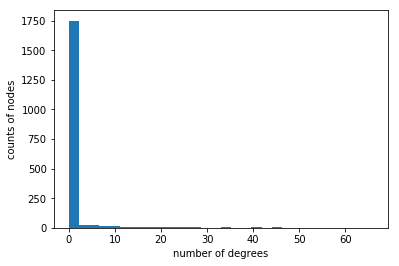

In [ ]:
# plt.hist(miRNAs_nodes_degrees[1].values())
plt.hist(targets_nodes_degrees[0].values(), bins=30)
plt.ylabel('counts of nodes')
plt.xlabel('number of degrees')
plt.show()